We will be utilizing prewritten codes by Maria Koshkina.

The idea is pretty simple and explained using a simple image as below:

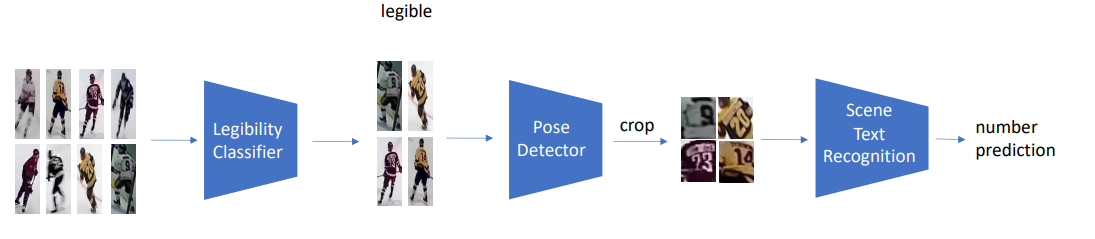

The algorithm works and has some good results on a random video of football found in youtube. 

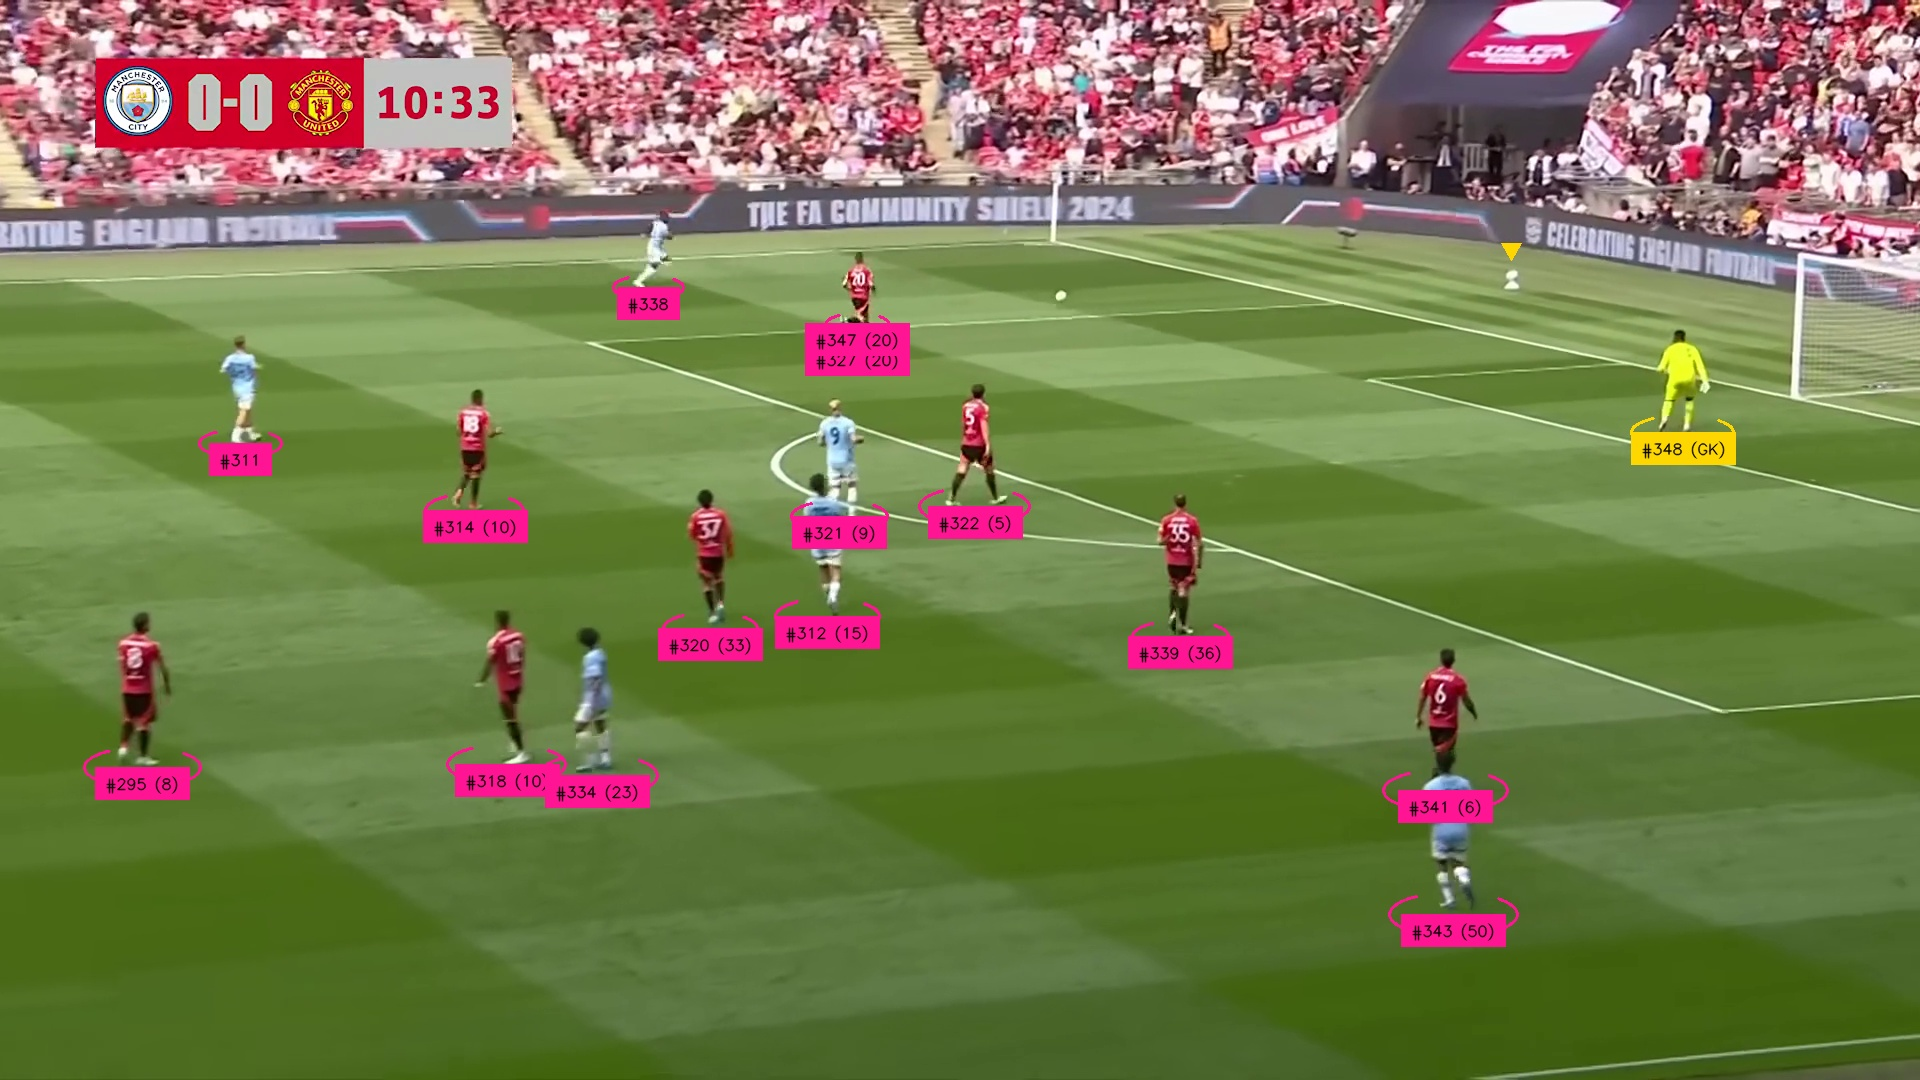

Above is a result for a single from the youtube video. The original data of JN-Soccernet has some problems with its dataset which only consists 45 unique labels in training dataset and 55 unique labels in testing dataset which kind of effects the performance on a random video but on an avg its good

In [ ]:
! git clone https://github.com/mkoshkina/jersey-number-pipeline.git

The problem of this git is you have to change a single line of code
from sam.sam import SAM in some python file to 

from sam2.sam import SAM because the file is named sam2

Also, make sure to add models on the correct path. If you suffer any problems, please contact me at chaudharysahil379@gmail.com or contact her by raising a new issue

In [ ]:
import os
import torch
from PIL import Image
import cv2
import legibility_classifier as lc
import helpers
import configuration as config
import gdown
import sys
from strhub.models.utils import load_from_checkpoint
from strhub.data.module import SceneTextDataModule


In [ ]:

def ensure_models_exist():
    """Download models if they don't exist"""
    # Create models directory if it doesn't exist
    os.makedirs('models', exist_ok=True)
    
    # SoccerNet legibility model
    legibility_model_path = config.dataset['SoccerNet']['legibility_model']
    if not os.path.exists(legibility_model_path):
        print(f"Downloading legibility model...")
        gdown.download(config.dataset['SoccerNet']['legibility_model_url'], 
                      legibility_model_path)
    
    # SoccerNet STR model
    str_model_path = config.dataset['SoccerNet']['str_model']
    if not os.path.exists(str_model_path):
        print(f"Downloading STR model...")
        gdown.download(config.dataset['SoccerNet']['str_model_url'], 
                      str_model_path)
    
    # Check if models were downloaded successfully
    if not os.path.exists(legibility_model_path) or not os.path.exists(str_model_path):
        raise FileNotFoundError("Failed to download models. Please download them manually from the URLs in configuration.py")

def process_single_image(image_path):
    # try:
    # Ensure models exist before processing
    ensure_models_exist()
    
    # Step 1: Legibility Classification
    legibility_results = lc.run(
        [image_path], 
        config.dataset['SoccerNet']['legibility_model'],  # Changed to SoccerNet
        threshold=0.5,
        arch=config.dataset['SoccerNet']['legibility_model_arch']  # Using specified architecture
    )
    
    if legibility_results[0] < 0.5:
        # print("Image is not legible")
        return None

    # Step 2: Pose Detection & Cropping
    # First generate a simple JSON for pose detector
    helpers.generate_json([image_path], "temp_pose_input.json")
    
    # Run pose detection
    os.system(f"conda run -n {config.pose_env} python3 pose.py {config.pose_home}/configs/body/2d_kpt_sview_rgb_img/topdown_heatmap/coco/ViTPose_huge_coco_256x192.py \
        {config.pose_home}/checkpoints/vitpose-h.pth --img-root / --json-file temp_pose_input.json \
        --out-json temp_pose_output.json")

    # Generate crop
    # Ensure the temp_crops directory exists
    crops_dir = os.path.join(os.getcwd(), 'temp_crops')
    os.makedirs(crops_dir, exist_ok=True)
    helpers.generate_crops_for_all("temp_pose_output.json", crops_dir)


    # Step 3: Number Recognition using PARSeq
    model = load_from_checkpoint(config.dataset['SoccerNet']['str_model'])  # Changed to SoccerNet
    model.eval()
    
    # Process the cropped image
    crop_path = os.path.join(crops_dir, os.path.basename(image_path))
    image = Image.open(crop_path).convert('RGB')
    transform = SceneTextDataModule.get_transform(model.hparams.img_size)
    image = transform(image)
    image = image.unsqueeze(0)
    
    with torch.no_grad():
        logits = model(image.to(model.device))
        probs = logits.softmax(-1)
        preds, probs = model.tokenizer.decode(probs)

    return preds[0], probs[0]
    
    # except Exception as e:
    #     print(f"Error processing image: {e}")
    #     return -1, 0.0

In [ ]:

# Usage
image_path = "/home/sahilc/Pictures/Screenshots/Screenshot from 2024-11-08 03-02-44.png"
predicted_number, probability = process_single_image(image_path)
print(f"Predicted Jersey Number: {predicted_number} with probability {probability}")

In [ ]:
import torch
import torch.nn as nn
import supervision as sv
from ultralytics import YOLO
from tqdm import tqdm
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import os
import argparse
import cv2
import time
# default dict
from collections import defaultdict

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
from pathlib import Path
import cv2
import json
import torch.nn.functional as F

In [ ]:
class JerseyTracker:
    """JerseyTracker class for tracking players and their jersey numbers using the improved model"""
    def __init__(self, player_model_path, device='cuda'):
        self.device = device
        
        # Initialize player tracking model
        self.player_model = YOLO(player_model_path)
        
        # Initialize tracking components
        self.tracker = sv.ByteTrack()
        self.tracker.reset()
        
        # Initialize jersey number tracking dictionary
        self.jersey_tracker = defaultdict(lambda: {'number': -1, 'confidence': 0, 'count': 0})
        
        # Constants and colors for different classes
        self.BALL_ID = 0
        self.PLAYER_ID = 1
        self.GOALKEEPER_ID = 2
        self.REFEREE_ID = 3
        
        self.colors = {
            self.PLAYER_ID: '#00BFFF',      # Light blue for players
            self.GOALKEEPER_ID: '#FF1493',   # Pink for goalkeepers
            self.REFEREE_ID: '#FFD700'       # Gold for referees
        }

        # Initialize the improved jersey number detection
        self.initialize_jersey_detector()

    def initialize_jersey_detector(self):
        """Initialize components for improved jersey number detection"""
        # Ensure models exist (download if needed)
        ensure_models_exist()  # From testing_claims.ipynb
        
    def predict_jersey_number(self, crop):
        """Predict jersey number using the improved model from testing_claims.ipynb"""
        # try:
        # Convert crop to PIL Image and save temporarily
        # temp_path = "temp_crops/temp_crop.jpg"
        # use different names for crops (if the same name is used, the crop will be overwritten). we wish to avoid this
        crops_dir = os.path.join(os.getcwd(), 'temp_crops')
        os.makedirs(crops_dir, exist_ok=True)

        # Generate a unique file path for this crop
        temp_path = os.path.join(crops_dir, f"temp_crop_{time.time()}.jpg") 

        cv2.imwrite(temp_path, crop)
        
        # Use the improved process_single_image function
        result = process_single_image(temp_path)
        if result is None:
            return -1, 0.0
        else:
            number, confidence = result
            # get any element from confidence tensor and assign it to confidence
            confidence = confidence[0]
        
        print(f"Predicted jersey number: {number} with confidence {confidence}")
            
        return number, float(confidence)
            
        # except Exception as e:
        #     print(f"Error in jersey prediction: {str(e)}")
        #     return -1, 0.0

    def process_frame(self, frame, confidence=0.3):
        """Process a single frame"""
        # Get detections from player tracking model
        result = self.player_model(frame, conf=confidence, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)

        # Separate ball detections
        ball_detections = detections[detections.class_id == self.BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        # Process other detections
        all_detections = detections[detections.class_id != self.BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        all_detections = self.tracker.update_with_detections(all_detections)

        # Separate detections by class
        players_detections = all_detections[all_detections.class_id == self.PLAYER_ID]
        goalkeeper_detections = all_detections[all_detections.class_id == self.GOALKEEPER_ID]
        referees_detections = all_detections[all_detections.class_id == self.REFEREE_ID]

        # Process jersey numbers for players
        jersey_labels = []
        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        
        for crop, tracker_id in zip(players_crops, players_detections.tracker_id):
            number, conf = self.predict_jersey_number(crop)
            
            if number != -1 and conf > 0.96:  # Confidence threshold
                self.update_jersey_tracking(tracker_id, number, conf)
            
            tracked_number = self.jersey_tracker[tracker_id]['number']
            # tracked_number = number # Use the predicted number directly
            if tracked_number != -1:
                print(f"Player {tracker_id} has jersey number {tracked_number}")
                jersey_labels.append(f"#{tracker_id} ({tracked_number})")
            else:
                jersey_labels.append(f"#{tracker_id}")

        # We will do something cute here. I rely on my perfect tracker and assume its good.
        # Now, I will not identify the jersey number of the player at each frame. I will use jersey number detection
        # until the tracked player isnot -1. Once the tracked player's jersey number is updated by a certain number of confidence, we will keep on using the same jersey number for the player.
        # This will reduce the number of calls to the jersey number detection model and will also make the tracking more robust.

        # Process jersey numbers for players
        # for tracker_id in players_detections.tracker_id:
        #     tracked_number = self.jersey_tracker[tracker_id]['number']
        #     if tracked_number != -1:
        #         jersey_labels.append(f"#{tracker_id} ({tracked_number})")
        #     else:
        #         crop = players_crops[tracker_id]
        #         number, conf = self.predict_jersey_number(crop)
                
        #         if number != -1 and conf > 0.96:
        #             self.update_jersey_tracking(tracker_id, number, conf)
        #             jersey_labels.append(f"#{tracker_id} ({number})")
        #         else:
        #             jersey_labels.append(f"#{tracker_id}")


        # Create labels for goalkeepers and referees
        goalkeeper_labels = [f"#{id} (GK)" for id in goalkeeper_detections.tracker_id]
        referee_labels = [f"#{id} (REF)" for id in referees_detections.tracker_id]

        # Merge all detections
        all_detections = sv.Detections.merge([
            players_detections,
            goalkeeper_detections,
            referees_detections
        ])

        # Combine all labels
        all_labels = jersey_labels + goalkeeper_labels + referee_labels

        return ball_detections, all_detections, all_labels

    def update_jersey_tracking(self, tracker_id, number, confidence):
        """Update jersey number tracking for a player"""
        # Only update if new confidence is higher
        if confidence > self.jersey_tracker[tracker_id]['confidence']:
            self.jersey_tracker[tracker_id]['number'] = number
            self.jersey_tracker[tracker_id]['confidence'] = confidence
        self.jersey_tracker[tracker_id]['count'] += 1

In [ ]:
def process_video(source_video_path, target_video_path, player_model_path, confidence=0.3):
    """Process entire video with jersey tracking and player detection"""
    # Initialize video components
    video_info = sv.VideoInfo.from_video_path(source_video_path)
    video_sink = sv.VideoSink(target_video_path, video_info)
    frame_generator = sv.get_video_frames_generator(source_video_path)
    
    # Initialize tracker with only player model (jersey model is handled internally)
    jersey_tracker = JerseyTracker(player_model_path)
    
    # Initialize annotators
    colors = [jersey_tracker.colors[jersey_tracker.PLAYER_ID],
              jersey_tracker.colors[jersey_tracker.GOALKEEPER_ID],
              jersey_tracker.colors[jersey_tracker.REFEREE_ID]]
    
    ellipse_annotator = sv.EllipseAnnotator(
        color=sv.ColorPalette.from_hex(colors),
        thickness=2
    )
    label_annotator = sv.LabelAnnotator(
        color=sv.ColorPalette.from_hex(colors),
        text_color=sv.Color.from_hex('#000000'),
        text_position=sv.Position.BOTTOM_CENTER,
    )
    triangle_annotator = sv.TriangleAnnotator(
        color=sv.Color.from_hex('#FFD700'),
        base=20, height=17
    )
    output_folder = "/home/sahilc/Desktop/Soccer Analysis Project/Experiments/Output"
    # Process video
    print("Processing video...")
    frame_count = 0
    with video_sink:
        for frame in tqdm(frame_generator, total=video_info.total_frames):
            try:
                ball_detections, all_detections, all_labels = jersey_tracker.process_frame(
                    frame, confidence
                )
                
                # Annotate frame
                annotated_frame = frame.copy()
                annotated_frame = ellipse_annotator.annotate(annotated_frame, all_detections)
                annotated_frame = label_annotator.annotate(
                    annotated_frame, all_detections, all_labels
                )
                annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)

                # Since video takes a lot of time. Let's make sure the program works for each frames. thus, let's save the edited frame at each iteration
                # Save annotated frame
                output_frame = os.path.join(output_folder, f"frame_{frame_count}.jpg")
                cv2.imwrite(output_frame, annotated_frame)
                frame_count += 1
                
                video_sink.write_frame(annotated_frame)
            except Exception as e:
                print(f"Error processing frame: {str(e)}")
                # Write original frame if there's an error
                video_sink.write_frame(frame)
                continue

In [ ]:
source_video = "/home/sahilc/Desktop/Soccer Analysis Project/Experiments/Input/trimmed.mp4"
target_video = "/home/sahilc/Desktop/Soccer Analysis Project/Experiments/Output/annotated_numbers.mp4"
player_model = "/home/sahilc/Desktop/Soccer Analysis Project/Player Reidentification and Tracking/Assets/best.pt"

process_video(source_video, target_video, player_model, confidence=0.5)

In [ ]:
print('done with everything')